# Asteroid Families

## The Sloan Digital Sky Survey Moving Object Catalog (SDSSMOC)

http://faculty.washington.edu/ivezic/sdssmoc/sdssmoc4.html

http://www.astro.washington.edu/users/ivezic/sdssmoc/ADR4.dat.gz

In [1]:
import healpy as hp
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# load table description
with open("ADR4_dtypes.json") as json_file:
    adr4_dtypes = (pd.DataFrame(json.load(json_file))
        .set_index("name").sort_values("column_number"))

In [3]:
adr4_dtypes.head()

,column_number,description,format,unit,missing_constant
name,,,,,
smoc_id,1,SDSS MOC id,a6,NaN,NaN
obj_id_run,2,first portion of the SDSS object id,i4,NaN,NaN
obj_id_col,3,second portion of the SDSS object id,i4,NaN,NaN
obj_id_field,4,third portion of the SDSS object id,i4,NaN,NaN
obj_id_obj,5,fourth portion of the SDSS object id,i4,NaN,NaN


In [4]:
# load data table
moc = pd.DataFrame(np.loadtxt("ADR4.dat",
    dtype=[(d.Index, d.format) for d in adr4_dtypes.itertuples()]))

In [5]:
for col in moc:
    dtype = adr4_dtypes.loc[col]
    
    # insert null values
    if not pd.isnull(dtype.missing_constant):
        moc[col] = moc[col].replace(dtype.missing_constant, np.nan)
        
    # convert angles
    if dtype.unit == "degree":
        moc[col] = np.deg2rad(moc[col])
        
    if dtype.unit == "degree_per_day":
        moc[col] = np.deg2rad(moc[col]) 

In [6]:
# convert epochs
moc["epoch_osc"] += 2400000

In [7]:
# compute colors
moc["ri_col"] = moc["r_mag"] - moc["i_mag"]
moc["gr_col"] = moc["g_mag"] - moc["r_mag"]
moc["iz_col"] = moc["i_mag"] - moc["z_mag"]

In [8]:
# color classification
def classify(d):
    if d["a_col"] < 0:
        return "C"
    else:
        if d["iz_col"] > -0.15:
            return "S"
        else:
            return "V"

moc["class"] = moc.apply(classify, axis="columns")

In [9]:
# select all detected known asteroids
moc = moc[(moc["ast_flag"] == 1) & (moc["ast_det_count"] >= 1)]

In [10]:
len(moc)

220101

In [11]:
# number of asteroids with proper orbital elements
len(moc["a_prop"].dropna())

187650

In [12]:
#moc.head()

## Charts

### SDSS Observations

Resolution: 7.33 deg


/usr/local/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/usr/local/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/usr/local/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and i

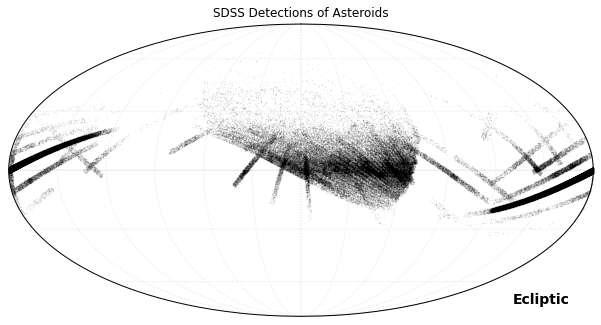

In [13]:
NSIDE = 8
print(f"Resolution: {hp.nside2resol(NSIDE, arcmin=True) / 60:.2f} deg")

NPIX = hp.nside2npix(NSIDE)
empty_map = np.zeros(NPIX) + np.inf

hp.mollview(
    map=empty_map,
    title="SDSS Detections of Asteroids",
    flip="astro",
    rot=(180, 0, 0),
    coord="E",
    cbar=False)

hp.graticule(
    verbose=False,
    color="0.9",
    zorder=1)

hp.projscatter(
    np.rad2deg(moc["lambda"]),
    np.rad2deg(moc["beta"]),
    lonlat=True,
    s=0.1,
    alpha=0.1,
    color="k",
    zorder=2)

plt.show()

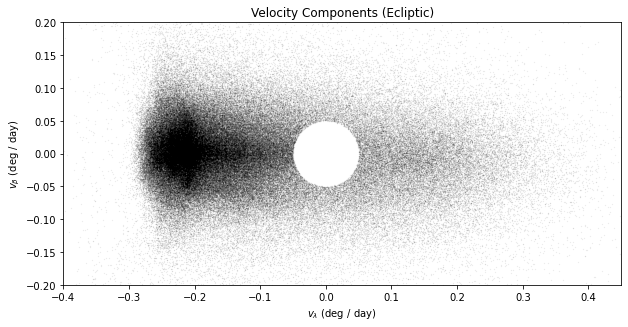

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    np.rad2deg(moc["vlambda"]),
    np.rad2deg(moc["vbeta"]),
    s=0.1,
    alpha=0.1,
    color="black")

ax.set_xlim([-0.4, 0.45])
ax.set_ylim([-0.2, 0.2])
ax.set_aspect("equal")

ax.set_title("Velocity Components (Ecliptic)")
ax.set_xlabel(r"$v_\lambda$ (deg / day)")
ax.set_ylabel(r"$v_\beta$ (deg / day)")

plt.show()

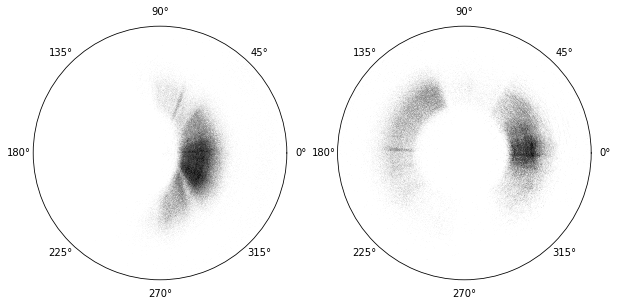

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw=dict(projection="polar"))

for i, (angle, radius) in enumerate([["phi", "r_geo"], ["lambda", "r_helio"]]):
    ax[i].scatter(
        moc[angle],
        moc[radius],
        s=0.1,
        alpha=0.02,
        color="black",
        zorder=2)
    
    ax[i].set_ylim([0, 5])
    ax[i].set_yticklabels([])
    ax[i].grid(color="0.9", zorder=1)

plt.show()

### Asteroid Families

In [16]:
color = {"C": "C0", "S": "C1", "V": "C2"}

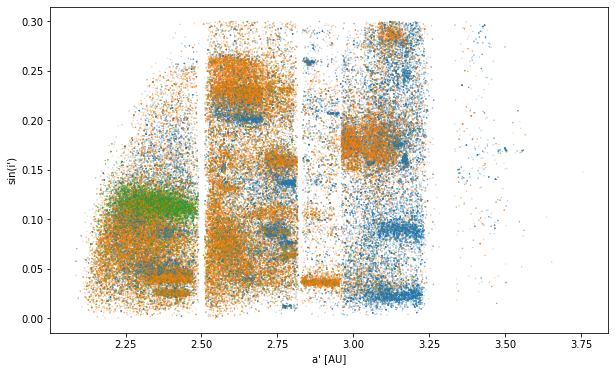

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    moc["a_prop"],
    moc["sini_prop"],
    #moc["a_osc"],
    #np.sin(moc["i_osc"]),    
    s=0.1,
    alpha=0.5,
    c=[color[d] for d in moc["class"]])

ax.set_xlabel("a' [AU]")
ax.set_ylabel("sin(i')")

plt.show()

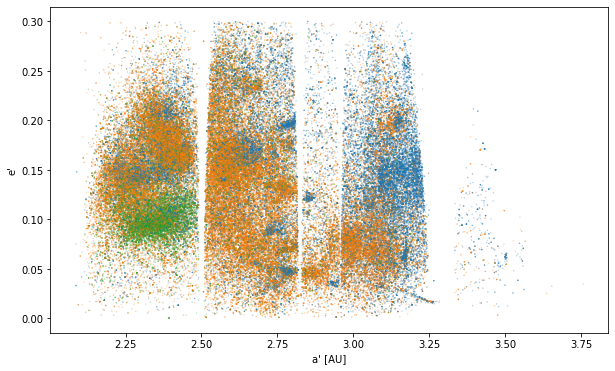

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    moc["a_prop"],
    moc["e_prop"],
    s=0.1,
    alpha=0.5,
    c=[color[d] for d in moc["class"]])

ax.set_xlabel("a' [AU]")
ax.set_ylabel("e'")

plt.show()

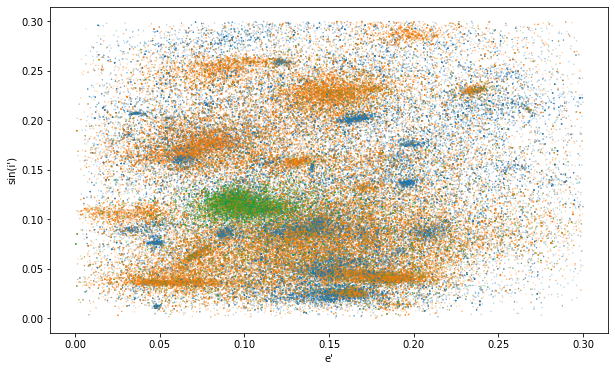

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(
    moc["e_prop"],
    moc["sini_prop"],
    s=0.1,
    alpha=0.5,
    c=[color[d] for d in moc["class"]],)

ax.set_xlabel("e'")
ax.set_ylabel("sin(i')")

plt.show()

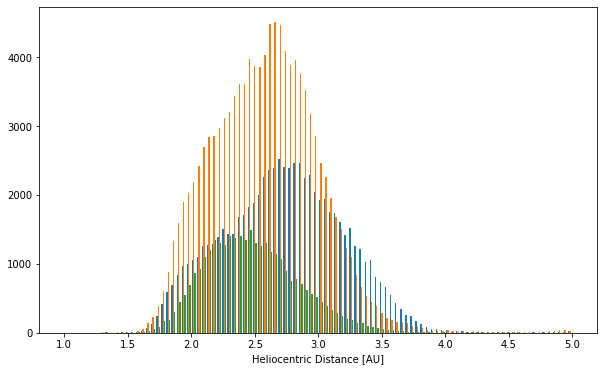

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist([
    moc[moc["class"] == "C"]["r_helio"],
    moc[moc["class"] == "S"]["r_helio"],
    moc[moc["class"] == "V"]["r_helio"]],
    color=[color["C"], color["S"], color["V"]],
    #stacked=True,
    range=(1, 5),
    bins=100)

ax.set_xlabel("Heliocentric Distance [AU]")

plt.show()